In [89]:
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
import astropy as py
import pyspeckit
import astropy.units as u
import aplpy

from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.modeling.models import custom_model
from astropy.modeling.fitting import LevMarLSQFitter
from astropy import constants
from astropy.wcs import WCS
from astropy.nddata.utils import Cutout2D 

from scipy import constants as const
from scipy import optimize

from spectral_cube import SpectralCube

from pvextractor import extract_pv_slice, Path, PathFromCenter

from pyspeckit.cubes.mapplot import MapPlotter

%matplotlib inline
plt.rcParams["figure.figsize"] = (14,8)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize'] = 'xx-large'
plt.rcParams['ytick.labelsize'] = 'xx-large'
plt.rcParams.update({"text.usetex": False,
                     "font.family": "serif",
                     'xtick.direction': 'out',
                     'ytick.direction': 'in'})

In [90]:
class PVData(object):

    default_header_keys = {'position_reference': 'CRPIX1',
                           'd_pos': 'CDELT1',
                           'pos_unit': 'CUNIT1',
                           'v_lsr_channel': 'CRPIX2',
                           'd_vel': 'CDELT2',
                           'vlsr': 'CRVAL2',
                           'vel_unit': 'CUNIT2',
                           'data_unit': 'BUNIT'}

    def __init__(self, data, noise=None, position_reference=None, v_lsr_channel=None, d_pos=None, d_vel=None,
                 pos_unit=None, vel_unit=None, data_unit=None, vlsr=None, transpose=False):
        """Initialize a position-velocity data (PVData) object:
        Args:
            data (np.ndarray):
                Position-velocity data image.
            noise (float, optional):
                Uncertainty of `data` for parsing independent estimates. The code is using the standard deviation of
                `data` if not provided.
            position_reference (int, optional):
                Spatial index of the center of rotation in `data`.
            v_lsr_channel (int, optional):
                Spectral index of the local standard of rest in `data`.
            d_pos (float, optional):
                Increment in position in `pos_unit` per pixel.
            d_vel (float, optional):
                Increment in velocity in `vel_unit` per pixel.
            pos_unit (str, optional):
                Unit of spatial indexes per pixel.
            vel_unit (str, optional):
                Unit of spectral indexes per pixel.
            v_lsr (float, optional):
                Local standard of rest velocity in units of km/ s.
            transpose (bool, optional):
                Transpose the data array, if requested. This can be used if the first axis is not (spatial, velocity).
        """

        # Store input parameters
        self.data = np.squeeze(data)  # Get rid of additional axes
        self.noise = noise
        self.position_reference = int(position_reference)
        self.v_lsr_channel = int(v_lsr_channel)
        self.d_pos = d_pos
        self.d_vel = d_vel
        self.pos_unit = pos_unit
        self.vel_unit = vel_unit
        self.vlsr = vlsr

        # Check data validity
        if np.isnan(self.data).any():
            self.data = np.ma.masked_invalid(self.data)

        # Set noise if not provided
        if self.noise is None:
            self.noise = np.std(self.data)

        # Initialize future attributes
        self.min_channels = None
        self.max_channels = None
        self.extreme_channels = None

    @classmethod
    def from_file(cls, file_name, extension=None, transpose=False, **kwargs):
        """Initialize an object from a FITS file.
        Args:
            file_name (str):
                Path to the file.
            extension (int or str, optional):
                Index or name of the desired FITS extension.
            transpose (bool, optional):
                Transpose the data array, if requested. This can be used if the first axis is not (spatial, velocity).
        Keyword Args:
            Kwargs will overwrite the parameters extracted from the FITS header.
        Returns:
            pv_data (PVData object):
                Instance of the PVData class, based on the data and parameters from the FITS file.
        """

        # Read data from header
        data, hdr = fits.getdata(file_name, extension, header=True)

        # Extract other parameters from FITS header
        pars = {}
        for par, card in cls.default_header_keys.items():
            pars[par] = hdr.get(card)

        # Overwrite parameters from FITS header by kwargs
        pars.update(**kwargs)

        return cls(data=data, **pars, transpose=transpose)

    @property
    def shape(self):
        return self.data.shape

In [141]:
Coords_B335 = SkyCoord("19h37m0.9s","7d34m9.6s")
#Coords_B335 = SkyCoord("19h37m0.9s","7d34m9.49s")


distance = 164.5 * u.pc

vlsr = 8.3

# Arcsec to AU

In [142]:
def arcsec_au(d,theta) :
    return (d*theta*u.au)

# Load Cube

In [206]:
file = 'Documents/SO/B335_SO_medsub.fits'
#file = 'Documents/C18O/B335_Combine_C18O_HRA_rob05_fit1_01kms_3sigma_self_clean.fits'
#file = 'Documents/CS/B335_CS_medsub.fits'
#file = 'Documents/H13CO/B335_Combine_H13COp_32_rob05_2sigma_self_clean.fits'
#file = 'Documents/B335/data/B335_N2H+_10_K_v1.fits'
#file = 'Downloads/HD_163296_C18O_220GHz.robust_0.5.image.fits'
#file = 'Documents/H13CO/B335_Combine_H13COp_10_rob05_2sigma_self_clean.fits'

spectral_ax = 'Reversed'

#rest_freq = 260.25533900 * u.GHz
#rest_freq = 93.17339770 * u.GHz
#rest_freq = 342.8828503 * u.GHz

#rest_freq = 219.56035410 * u.GHz
rest_freq = 261.84368400 * u.GHz

#rest_freq = 86.7542884 * u.GHz

In [243]:
Cube = SpectralCube.read(file).with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=rest_freq)

In [226]:
from mpdaf.obj import Cube

t = Cube(file)

In [233]:
s = t.rebin(factor = (1,5,5))

# Define PV Cut

In [147]:
length = 1 * u.arcsec
angle = 10 * u.deg
width = 1

PV_cut = PathFromCenter(center=Coords_B335, length=length, angle=angle, width=width)

# Extract PV Diagram

In [148]:
pvdiagram = extract_pv_slice(cube=Cube, path=PV_cut, spacing=1)

# Save it

In [149]:
#file_PV = 'Documents/C18O/PVDiagram_C18O_1as_0deg.fits'
file_PV = 'Documents/SO/PVDiagram_SO_1as_10deg.fits'
#file_PV = 'Documents/H13CO/PVDiagram_H13CO_1as_Odeg.fits'
#file_PV = 'Documents/CS/PVDiagram_CS_05as_120deg.fits'
#file_PV = 'Documents/B335/PVDiagram_N2Hp_20as_10deg.fits'
#file_PV = 'Documents/H13CO/PVDiagam_H13CO_10_5as_10deg.fits'

pvdiagram.writeto(file_PV, overwrite=True)

# Change Header parameters

In [151]:
PV = PVData.from_file(file_PV)

PV.position_reference = PV.data.shape[1] // 2
PV.vel_unit = 'm/s'
PV.pos_unit = 'deg'

PV.vlsr /=1000
PV.vlsr = 0


nbr_channels = PV.data.shape[0]

#C18O
#PV.noise = 0.002269
#PV.noise = 1e-3

#SO
PV.noise = 7.42e-4

#H13CO
#PV.noise = 0.0039
#PV.noise =  0.0025

#CS
#PV.noise = rms = 0.001568

#N2Hp
#PV.noise = 0.177

sigma = 5.0

snr = PV.noise * sigma

# Compute offset w.r.t center of PV cut in AU

In [152]:
Offset = arcsec_au(d=distance.value,
                   theta=(((np.arange(PV.shape[1]) - PV.position_reference).astype(float)*PV.d_pos)*u.deg).to(u.arcsec).value)


In [153]:
Offset

<Quantity [-78.96 , -74.025, -69.09 , -64.155, -59.22 , -54.285, -49.35 ,
           -44.415, -39.48 , -34.545, -29.61 , -24.675, -19.74 , -14.805,
            -9.87 ,  -4.935,   0.   ,   4.935,   9.87 ,  14.805,  19.74 ,
            24.675,  29.61 ,  34.545,  39.48 ,  44.415,  49.35 ,  54.285,
            59.22 ,  64.155,  69.09 ,  74.025,  78.96 ] AU>

# Min Velocity

In [154]:
Min_velocity_chan = []
Min_velocity = []
Pos_min = []
Pix_min = []

for i in range(PV.data.shape[1]) :
    
    for j in range(nbr_channels) :
        
        if spectral_ax == 'Normal' :
        
            if PV.data[j,i] >= snr :
        
                Min_velocity_chan.append(j)
                Min_velocity.append(((((j)*np.abs(PV.d_vel))*u.m/u.s).to(u.km/u.s)).value + PV.vlsr)
                Pos_min.append(Offset[i].value)
                Pix_min.append(i)
                break
                
        elif spectral_ax == 'Reversed' :
            
            if PV.data[nbr_channels-1-j,i] >= snr :
        
                Min_velocity_chan.append(nbr_channels-1-j)
                Min_velocity.append(((((j)*np.abs(PV.d_vel))*u.m/u.s).to(u.km/u.s)).value + PV.vlsr)
                Pos_min.append(Offset[i].value)
                Pix_min.append(i)
                break

# Max Velocity

In [155]:
Max_velocity_chan = []
Max_velocity = []
Pos_max = []
Pix_max = []

for i in range(PV.data.shape[1]) :
    
    for j in range(nbr_channels) :
        
        if spectral_ax == 'Normal' :
        
            if PV.data[nbr_channels-1-j,i] >= snr :
        
                Max_velocity_chan.append(nbr_channels-1-j)
                Max_velocity.append(((((nbr_channels-1-j)*np.abs(PV.d_vel))*u.m/u.s).to(u.km/u.s)).value + PV.vlsr)
                Pos_max.append(Offset[i].value)
                Pix_max.append(i)
                break
                
        elif spectral_ax == 'Reversed' :
            
            if PV.data[j,i] >= snr :
        
                Max_velocity_chan.append(j)
                Max_velocity.append(((((nbr_channels-1-j)*np.abs(PV.d_vel))*u.m/u.s).to(u.km/u.s)).value + PV.vlsr)
                Pos_max.append(Offset[i].value)
                Pix_max.append(i)
                break

# Mass

In [156]:
Mass = 0.05

# Pure free fall model

$$
v_{ff} = \sqrt{\frac{2GM}{R}}
$$

In [157]:
def Freefall(x, mass=Mass, vlsr=vlsr):
    
     return np.sign(x) * np.sqrt(2 * constants.G * mass * constants.M_sun / np.abs(x)).to(u.km/u.s).value + vlsr

#  To do : Check Ulrich free fall model 
# stream line model 
# fit solid body rotation 


In [158]:
@custom_model
def Freefall_model(x, mass=Mass, vlsr=vlsr):
    
     return np.sign(x) * np.sqrt(2 * constants.G * mass * constants.M_sun / np.abs(x)/u.au).to(u.km/u.s).value + vlsr

# Keplerian model

$$
v_{kep} = \sqrt{\frac{GM}{R}}
$$

In [159]:
@custom_model
def Keplerian_model(x, mass=Mass, vlsr=vlsr, r0=0.):
    
    return np.sign(x-r0) * np.sqrt(constants.G * mass * constants.M_sun / np.abs(x-r0)/u.au).to(u.km/u.s).value + vlsr

In [160]:
def Keplerian(x, mass=Mass, vlsr=vlsr, r0=0.):

    return np.sign(x-r0) * np.sqrt(constants.G * mass * constants.M_sun / np.abs(x-r0)).to(u.km/u.s).value + vlsr

In [161]:
def PowerLaw(x, alpha, beta, xb, A):
    
    y1 = (A * (x/xb)**(-alpha)) [x < xb]
    y2 = (A * (x/xb)**(-beta) ) [x >= xb]
    y  = np.concatenate((y1,y2))
    
    return y

In [162]:
Keplerian_vel = Keplerian(x=Offset, mass=Mass, vlsr=vlsr)
Freefall_vel = Freefall(x=Offset, mass=Mass, vlsr=vlsr)

PowerLaw_vel = PowerLaw(x=Offset.value, alpha=0.5, beta=0.5, xb=1, A=8.3)

divide by zero encountered in true_divide
invalid value encountered in multiply
divide by zero encountered in power
invalid value encountered in power
divide by zero encountered in power
invalid value encountered in power


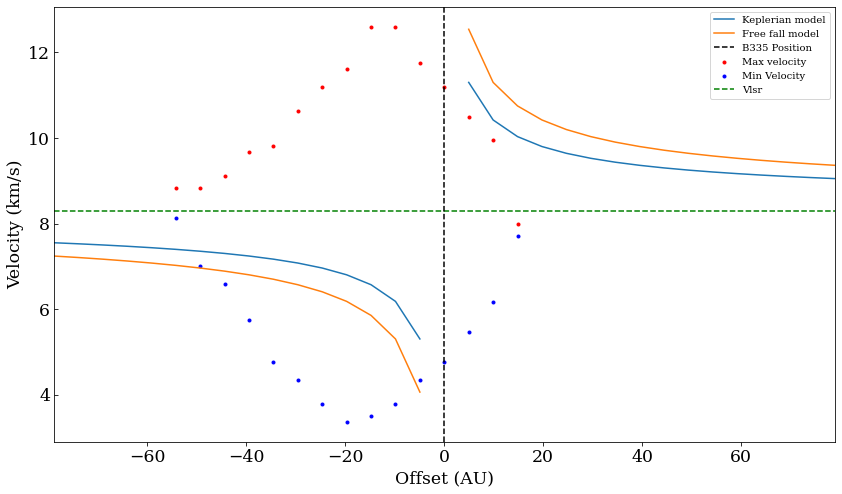

In [163]:
xmin = min(Offset.value)
xmax = max(Offset.value)

plt.scatter(Pos_max,Max_velocity, color = 'red', marker = '.',label = 'Max velocity')
plt.scatter(Pos_min, Min_velocity, color = 'blue', marker = '.', label = 'Min Velocity')
plt.plot(Offset.value, Keplerian_vel, label = 'Keplerian model')
plt.plot(Offset.value, Freefall_vel, label = 'Free fall model')
plt.xlabel('Offset (AU)')
plt.ylabel('Velocity (km/s)')
plt.axvline(0, linestyle='dashed', color = 'black', label = 'B335 Position')
plt.hlines(vlsr,xmin,xmax, linestyle='dashed', color = 'green', label = 'Vlsr')
plt.xlim(xmin,xmax)
plt.legend()

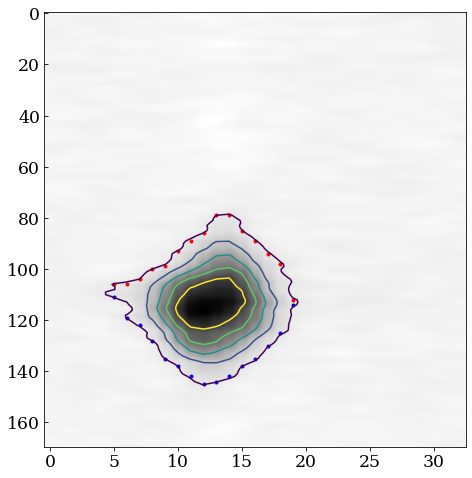

In [164]:
fig, ax = plt.subplots()
plt.contour(PV.data, levels = np.arange(5,50,10)*PV.noise)
plt.imshow(PV.data, cmap = 'Greys')
plt.scatter(Pix_max,Max_velocity_chan, color = 'red', marker = '.',label = 'Max velocity')
plt.scatter(Pix_min, Min_velocity_chan, color = 'blue', marker = '.', label = 'Min Velocity')
ax.set_aspect(0.2)
#plt.ylim(150,250)
#ax.invert_yaxis()

In [196]:
z = [[] for i in range(11)]

for i in range(11) :
    for j in range(11) :
        
        z[i-1].append(Cube[:,i+595,j+595].value)

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


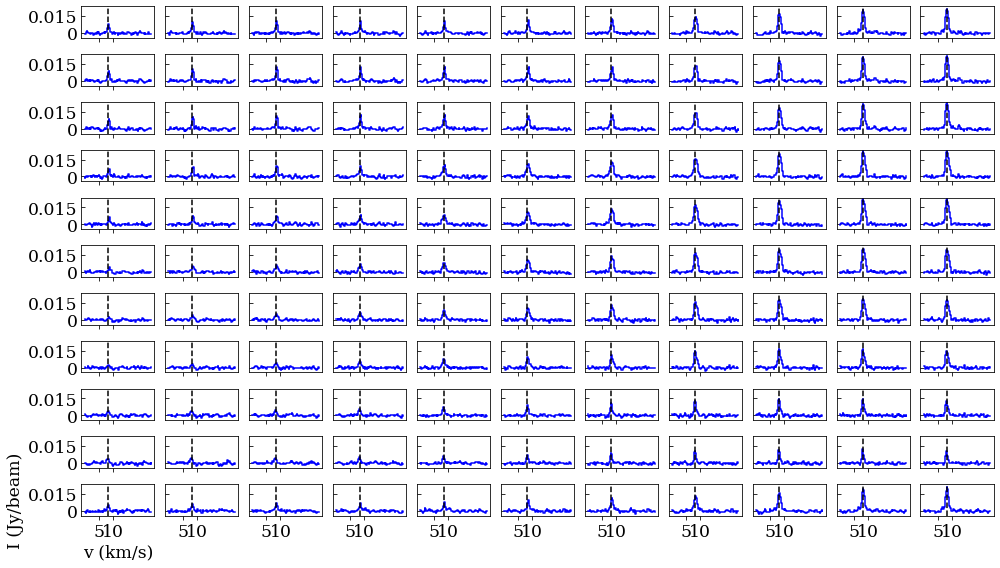

In [199]:
xmin = min(Cube.spectral_axis.value)
xmax = max(Cube.spectral_axis.value)


fig, axes = plt.subplots(nrows=11, ncols=11, sharex=True, sharey=True)

for n in range(11):
    
    for p in range(11): 
        
        axes[n,p].xaxis.set_ticklabels([])
        axes[n,p].yaxis.set_ticklabels([])
        axes[n,p].step(Cube.spectral_axis, z[n][p], color = 'blue')
        #axes[n,p].plot(Cube[:,n+00,p+600])
        axes[n,p].axvline(8.3, color = 'black', label = 'Vlsr', linestyle = 'dashed')
        
axes[10,0].set_ylabel('I (Jy/beam)')
axes[10,0].set_xlabel('v (km/s)')
axes[10,0].yaxis.set_ticklabels([0,0.015])
axes[10,0].yaxis.set_ticks([0,0.015])
axes[10,0].xaxis.set_ticklabels([5,10])
axes[10,0].xaxis.set_ticks([5,10])
        
plt.tight_layout()

# Fit Keplerian model to the data

In [179]:
test = []
position = []

for i in range(len(Max_velocity)//2):
    test.append(Max_velocity[i])
    position.append((Pos_max[i]))
    

#for i in range(len(Max_velocity)//2+1,len(Max_velocity)):
   # test.append(Min_velocity[i])
    #position.append(Pos_min[i])


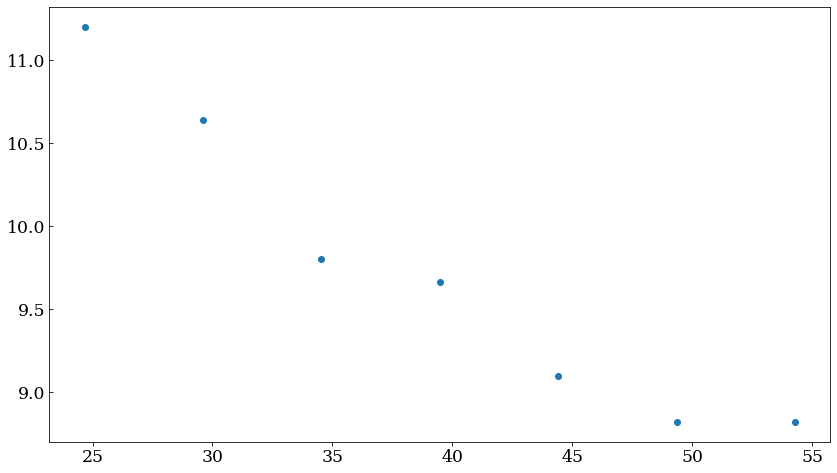

In [182]:
plt.scatter(np.abs(position), test)

In [173]:
fit_method = LevMarLSQFitter()
model_free=Freefall_model(mass=0.05,bounds={'mass': (0.0, None)})
model_kep=Keplerian_model(mass=0.05,bounds={'mass': (0.0, None)})

In [174]:
FF_fit = fit_method(model_free, np.flip(position), test)
Kep_fit = fit_method(model_kep, np.flip(position), test)

divide by zero encountered in true_divide
invalid value encountered in multiply


# Compute chi2

In [175]:
chi2_kep = np.sum(np.square(Kep_fit(position) - test))
chi2_free = np.sum(np.square(FF_fit(position) - test))

invalid value encountered in multiply


# Compute standard deviation

In [176]:
covariance = fit_method.fit_info['param_cov']

In [177]:
stddevs = np.sqrt(np.diag(covariance))

ValueError: Input must be 1- or 2-d.

In [ ]:
stddevs

# Show parameters found 

In [178]:
Kep_fit

<Keplerian_model(mass=0.05, vlsr=8.3, r0=0.)>

In [ ]:
plt.plot(position, test, '.', label='data')
plt.xlabel('Position offset (AU)')
plt.ylabel('Velocity (km/ s)')
plt.axhline(vlsr, c='k', ls='--', label=r'$v_{LSR}$')
plt.plot(np.flip(position), Kep_fit(position), label='Keplerian')

#plt.fill_between(position, Kep_fit(position), Kep_fit.vlsr, facecolor='tab:orange', alpha=.5)
#plt.plot(position, Keplerian_model(position), label='init')
plt.grid()
plt.legend()
plt.show()

# Curve_fit

In [ ]:
def Keplerian_model(x, mass=Mass, vlsr=vlsr, r0=0.):
    
    return np.sign(x-r0) * np.sqrt(constants.G * mass * constants.M_sun / np.abs(x-r0)/u.au).to(u.km/u.s).value + vlsr

In [191]:
popt_power, pcov_power = optimize.curve_fit(PowerLaw, np.abs(position), test, p0=np.asarray([0.5, 0.5, 40, 8.3]), 
                                method='trf', bounds=([0.01,0.01,10,8.2],[1.5,1.5,1100,8.4]) )

#popt, pcov = optimize.curve_fit(Keplerian_model, position, test, p0=np.asarray([0.05,8.3,0]), 
                               # method='trf')#, bounds=([0.001,8,-10],[1,9,10]))

In [184]:
perr = np.sqrt(np.diag(pcov_power))

In [192]:
popt_power

array([ 0.32712179,  0.28939202, 60.83403467,  8.316236  ])

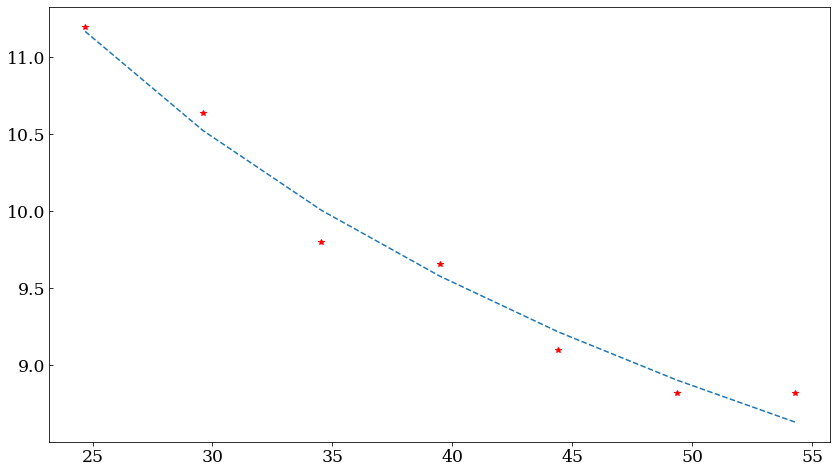

In [193]:
plt.plot(np.abs(position), test, 'r*')
plt.plot(np.abs(position), PowerLaw(np.abs(position), *popt_power), '--')